# Generative Adversarial Networks
# FEEC/Unicamp - July/2020
## Based on https://github.com/eriklindernoren/Keras-GAN/blob/master/gan/gan.py

In [ ]:
from __future__ import print_function, division

from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam

import matplotlib.pyplot as plt

import sys

import numpy as np

class GAN():
    def __init__(self):
        self.img_rows = 28
        self.img_cols = 28
        self.channels = 1
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.latent_dim = 100

        optimizer = Adam(0.0002, 0.5)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy',
            optimizer=optimizer,
            metrics=['accuracy'])

        # Build the generator
        self.generator = self.build_generator()

        # The generator takes noise as input and generates imgs
        z = Input(shape=(self.latent_dim,))
        img = self.generator(z)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The discriminator takes generated images as input and determines validity
        validity = self.discriminator(img)

        # The combined model  (stacked generator and discriminator)
        # Trains the generator to fool the discriminator
        self.combined = Model(z, validity)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)


    def build_generator(self):

        model = Sequential()

        model.add(Dense(256, input_dim=self.latent_dim))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(1024))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(np.prod(self.img_shape), activation='tanh'))
        model.add(Reshape(self.img_shape))

        model.summary()

        noise = Input(shape=(self.latent_dim,))
        img = model(noise)

        return Model(noise, img)

    def build_discriminator(self):

        model = Sequential()

        model.add(Flatten(input_shape=self.img_shape))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(256))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(1, activation='sigmoid'))
        model.summary()

        img = Input(shape=self.img_shape)
        validity = model(img)

        return Model(img, validity)

    def train(self, epochs, batch_size=128, sample_interval=50):

        # Load the dataset
        (X_train, _), (_, _) = mnist.load_data()

        # Rescale -1 to 1
        X_train = X_train / 127.5 - 1.
        X_train = np.expand_dims(X_train, axis=3)

        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))

        for epoch in range(epochs):

            # ---------------------
            #  Train Discriminator
            # ---------------------

            # Select a random batch of images
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs = X_train[idx]

            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))

            # Generate a batch of new images
            gen_imgs = self.generator.predict(noise)

            # Train the discriminator
            d_loss_real = self.discriminator.train_on_batch(imgs, valid)
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # ---------------------
            #  Train Generator
            # ---------------------

            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))

            # Train the generator (to have the discriminator label samples as valid)
            g_loss = self.combined.train_on_batch(noise, valid)

            # Plot the progress
            print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))

            # If at save interval => save generated image samples
            if epoch % sample_interval == 0:
                self.sample_images(epoch)

    def sample_images(self, epoch):
        r, c = 5, 5
        noise = np.random.normal(0, 1, (r * c, self.latent_dim))
        gen_imgs = self.generator.predict(noise)

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
                axs[i,j].axis('off')
                cnt += 1
        fig.savefig("/content/images/%d.png" % epoch) # Please, define the working directory appropriately
        plt.close()

if __name__ == '__main__':
    gan = GAN()
    gan.train(epochs=30000, batch_size=32, sample_interval=1000)

Streaming output truncated to the last 5000 lines.
25000 [D loss: 0.629577, acc.: 75.00%] [G loss: 1.061667]
25001 [D loss: 0.639427, acc.: 56.25%] [G loss: 1.035972]
25002 [D loss: 0.650389, acc.: 54.69%] [G loss: 1.208513]
25003 [D loss: 0.678959, acc.: 53.12%] [G loss: 0.958999]
25004 [D loss: 0.641736, acc.: 57.81%] [G loss: 0.968256]
25005 [D loss: 0.723116, acc.: 46.88%] [G loss: 0.978539]
25006 [D loss: 0.610962, acc.: 59.38%] [G loss: 1.043275]
25007 [D loss: 0.613783, acc.: 62.50%] [G loss: 1.041866]
25008 [D loss: 0.598875, acc.: 65.62%] [G loss: 1.158830]
25009 [D loss: 0.546387, acc.: 68.75%] [G loss: 1.155166]
25010 [D loss: 0.592372, acc.: 62.50%] [G loss: 1.103538]
25011 [D loss: 0.658089, acc.: 57.81%] [G loss: 1.013434]
25012 [D loss: 0.636851, acc.: 62.50%] [G loss: 0.989032]
25013 [D loss: 0.588420, acc.: 71.88%] [G loss: 1.002229]
25014 [D loss: 0.632900, acc.: 73.44%] [G loss: 0.854292]
25015 [D loss: 0.646150, acc.: 60.94%] [G loss: 0.960364]
25016 [D loss: 0.6922

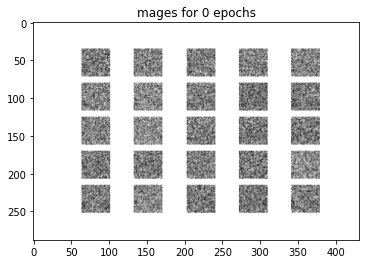

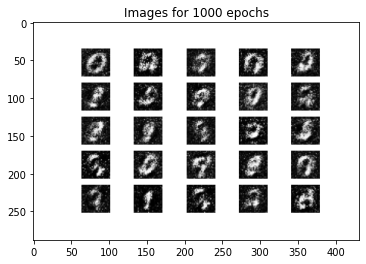

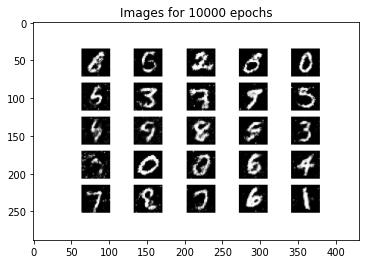

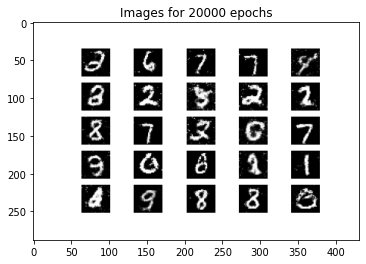

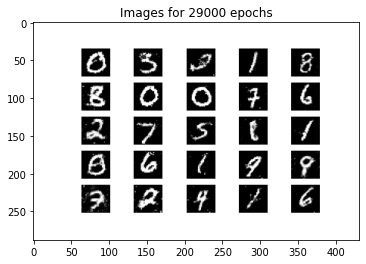

In [ ]:
import matplotlib.image as mpimg

image1 = mpimg.imread("/content/images/0.png") # Please, define the working directory appropriately
plt.imshow(image1)
plt.title("mages for 0 epochs")
plt.show()

image2 = mpimg.imread("/content/images/1000.png") # Please, define the working directory appropriately
plt.imshow(image2)
plt.title("Images for 1000 epochs")
plt.show()

image3 = mpimg.imread("/content/images/10000.png") # Please, define the working directory appropriately
plt.imshow(image3)
plt.title("Images for 10000 epochs")
plt.show()

image4 = mpimg.imread("/content/images/20000.png") # Please, define the working directory appropriately
plt.imshow(image4)
plt.title("Images for 20000 epochs")
plt.show()

image5 = mpimg.imread("/content/images/29000.png") # Please, define the working directory appropriately
plt.imshow(image5)
plt.title("Images for 29000 epochs")
plt.show()



  -----------------
 **Comentarios:** Verifica-se que o desempenho da máquina generativa vai melhorando ao longo do treinamento. Inicialmente, em 0 épocas, as imagens geradas foram essencialmente ruído; em 1000 épocas os dígitos gerados começaram a ganhar forma; a partir das 10000 épocas a qualidade dos dígitos gerados aumentou significativamente, e foi assim até o fim do treinamento. No entanto, mesmo nas etapas finais do treinamento da GAN, os digitos gerados não foram perfeitos, indicando que ainda existem margens para melhoras. 


#### GAN para a base Fashion MNIST

In [ ]:
from __future__ import print_function, division

from keras.datasets import fashion_mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam

import matplotlib.pyplot as plt

import sys

import numpy as np

class GAN():
    def __init__(self):
        self.img_rows = 28
        self.img_cols = 28
        self.channels = 1
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.latent_dim = 100

        optimizer = Adam(0.0002, 0.5)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy',
            optimizer=optimizer,
            metrics=['accuracy'])

        # Build the generator
        self.generator = self.build_generator()

        # The generator takes noise as input and generates imgs
        z = Input(shape=(self.latent_dim,))
        img = self.generator(z)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The discriminator takes generated images as input and determines validity
        validity = self.discriminator(img)

        # The combined model  (stacked generator and discriminator)
        # Trains the generator to fool the discriminator
        self.combined = Model(z, validity)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)


    def build_generator(self):

        model = Sequential()

        model.add(Dense(256, input_dim=self.latent_dim))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(1024))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(np.prod(self.img_shape), activation='tanh'))
        model.add(Reshape(self.img_shape))

        model.summary()

        noise = Input(shape=(self.latent_dim,))
        img = model(noise)

        return Model(noise, img)

    def build_discriminator(self):

        model = Sequential()

        model.add(Flatten(input_shape=self.img_shape))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(256))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(1, activation='sigmoid'))
        model.summary()

        img = Input(shape=self.img_shape)
        validity = model(img)

        return Model(img, validity)

    def train(self, epochs, batch_size=128, sample_interval=50):

        # Load the dataset
        (X_train, _), (_, _) = fashion_mnist.load_data()

        # Rescale -1 to 1
        X_train = X_train / 127.5 - 1.
        X_train = np.expand_dims(X_train, axis=3)

        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))

        for epoch in range(epochs):

            # ---------------------
            #  Train Discriminator
            # ---------------------

            # Select a random batch of images
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs = X_train[idx]

            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))

            # Generate a batch of new images
            gen_imgs = self.generator.predict(noise)

            # Train the discriminator
            d_loss_real = self.discriminator.train_on_batch(imgs, valid)
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # ---------------------
            #  Train Generator
            # ---------------------

            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))

            # Train the generator (to have the discriminator label samples as valid)
            g_loss = self.combined.train_on_batch(noise, valid)

            # Plot the progress
            print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))

            # If at save interval => save generated image samples
            if epoch % sample_interval == 0:
                self.sample_images(epoch)

    def sample_images(self, epoch):
        r, c = 5, 5
        noise = np.random.normal(0, 1, (r * c, self.latent_dim))
        gen_imgs = self.generator.predict(noise)

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
                axs[i,j].axis('off')
                cnt += 1
        fig.savefig("/content/images_2/%d.png" % epoch) # Please, define the working directory appropriately
        plt.close()

if __name__ == '__main__':
    gan = GAN()
    gan.train(epochs=60001, batch_size=32, sample_interval=1000)

Streaming output truncated to the last 5000 lines.
55001 [D loss: 0.576650, acc.: 65.62%] [G loss: 1.046310]
55002 [D loss: 0.630792, acc.: 65.62%] [G loss: 1.090612]
55003 [D loss: 0.564074, acc.: 70.31%] [G loss: 1.071913]
55004 [D loss: 0.577910, acc.: 75.00%] [G loss: 1.093818]
55005 [D loss: 0.729326, acc.: 53.12%] [G loss: 1.135627]
55006 [D loss: 0.632352, acc.: 60.94%] [G loss: 0.938896]
55007 [D loss: 0.605138, acc.: 64.06%] [G loss: 0.917990]
55008 [D loss: 0.653596, acc.: 57.81%] [G loss: 0.991916]
55009 [D loss: 0.622745, acc.: 60.94%] [G loss: 1.170717]
55010 [D loss: 0.642837, acc.: 59.38%] [G loss: 1.141324]
55011 [D loss: 0.562320, acc.: 70.31%] [G loss: 0.922876]
55012 [D loss: 0.665151, acc.: 62.50%] [G loss: 0.932953]
55013 [D loss: 0.527797, acc.: 76.56%] [G loss: 0.920276]
55014 [D loss: 0.602162, acc.: 65.62%] [G loss: 1.098374]
55015 [D loss: 0.657532, acc.: 59.38%] [G loss: 0.991391]
55016 [D loss: 0.618409, acc.: 68.75%] [G loss: 0.922267]
55017 [D loss: 0.6786

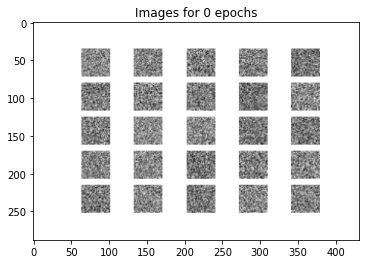

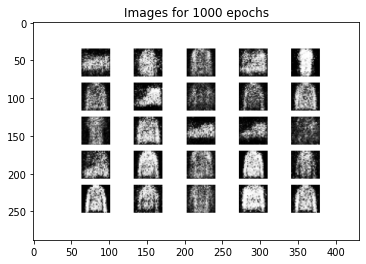

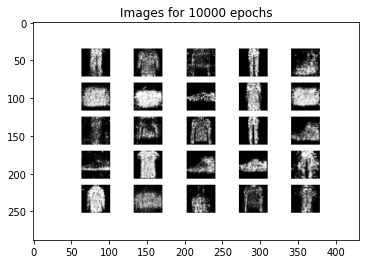

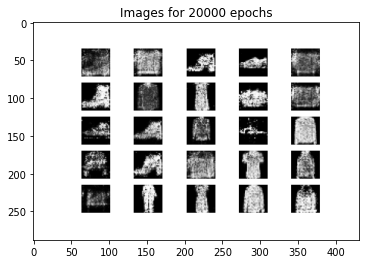

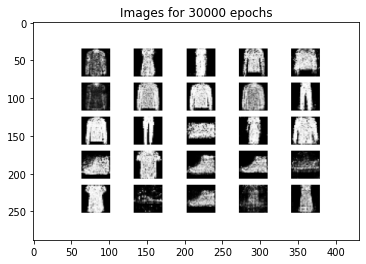

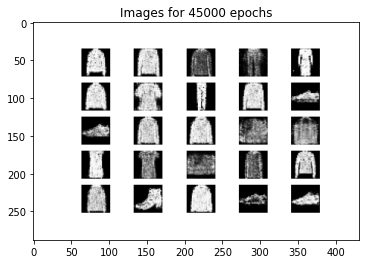

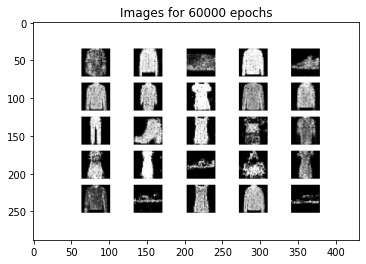

In [ ]:
import matplotlib.image as mpimg

image1 = mpimg.imread("/content/images_2/0.png") # Please, define the working directory appropriately
plt.imshow(image1)
plt.title("Images for 0 epochs")
plt.show()

image2 = mpimg.imread("/content/images_2/1000.png") # Please, define the working directory appropriately
plt.imshow(image2)
plt.title("Images for 1000 epochs")
plt.show()

image3 = mpimg.imread("/content/images_2/10000.png") # Please, define the working directory appropriately
plt.imshow(image3)
plt.title("Images for 10000 epochs")
plt.show()

image4 = mpimg.imread("/content/images_2/20000.png") # Please, define the working directory appropriately
plt.imshow(image4)
plt.title("Images for 20000 epochs")
plt.show()

image5 = mpimg.imread("/content/images_2/30000.png") # Please, define the working directory appropriately
plt.imshow(image5)
plt.title("Images for 30000 epochs")
plt.show()

image6 = mpimg.imread("/content/images_2/45000.png") # Please, define the working directory appropriately
plt.imshow(image6)
plt.title("Images for 45000 epochs")
plt.show()

image7 = mpimg.imread("/content/images_2/60000.png") # Please, define the working directory appropriately
plt.imshow(image7)
plt.title("Images for 60000 epochs")
plt.show()

  -----------------
 **Comentarios:** De modo similar à base MNIST é possível perceber o ganho de desempenho da máquina generativa ao longo das épocas. Apesar disso, por se tratar de uma base de dados mais diversa, o treinamento demandou uma quantidade maior de épocas para serem geradas imagens de qualidade. Não obstante, à exemplo da base MNIST, as imagens geradas ao fim do treinamento ainda não são indistinguíveis das originais, indicando ainda ser possível a obtenção de melhores resultados. 
